# Сравнение топологии транспортной сети регионов РФ
на данных междугородных перемещений пассажирского транспорта, предоставленных Туту.ру

----------

Подготовил [Вадим Сафронов](https://www.linkedin.com/in/vadymsafronov/) для участников соревнований. 

Желающих закопаться в графы всегда рады видеть в каналах #network_analysis и #class_cs224w

---------

**Последовательность действий следующая:**
* берём все виды транспорта,
* строим направленный граф,
* считаем все возможные мотифы размерности в три вершины (т.к. в четыре - размер выхода считалки в 30 гигов получается и пока его ворочать не особо хочется),
* количество вхождений в мотифы - это наш стартовый вектор признаков вершин,
* его сворачиваем трижды (т.к. эффективный диаметр 90% графа у нас ~3),
* всё это пихаем в kmeans (для проверки гипотезы компактности),
* суммируем полученные вектора и получаем приближение теста изоморфизма Вейсфейлера-Лемана для регионов, либо усредняем и получаем масштабно-инвариантное отображение региона. 

In [1]:
# import snap
import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.special import xlogy

from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
import os

In [3]:
def basic_stats(G):
    stats = {
        'Short info:\n': nx.info(G),
        'Selfloops edges: ': nx.number_of_selfloops(G),
    }
    for i, j in stats.items():
        print('{0}{1}'.format(i, j))

In [4]:
df = pd.read_csv('https://github.com/ods-ai-ml4sg/covid19-tutu/raw/master/data/extended_graph.csv', sep=';')
df.head()

,Unnamed: 0,source,target,pass_day,transport,source_lat,source_lng,target_lat,target_lng,target_population,source_population,source_coords,target_coords,source_country,source_county,source_region,target_country,target_county,target_region
0,0,Москва,Симферополь (Крым),5314.700000,avia,55.479205,37.327330,44.952146,34.102486,332317.0,11514330.0,"(37.3273304, 55.4792046)","(34.1024858, 44.9521457)",Russia,Podolsky,Moscow City,Russia,Simferopolska,Crimea
1,1,Москва,Сочи,4976.633333,avia,55.479205,37.327330,43.585482,39.723109,343285.0,11514330.0,"(37.3273304, 55.4792046)","(39.723109, 43.5854823)",Russia,Podolsky,Moscow City,Russia,Sochi,Krasnodar
2,2,Симферополь (Крым),Москва,5194.066667,avia,44.952146,34.102486,55.479205,37.327330,11514330.0,332317.0,"(34.1024858, 44.9521457)","(37.3273304, 55.4792046)",Russia,Simferopolska,Crimea,Russia,Podolsky,Moscow City
3,3,Сочи,Москва,4776.600000,avia,43.585482,39.723109,55.479205,37.327330,11514330.0,343285.0,"(39.723109, 43.5854823)","(37.3273304, 55.4792046)",Russia,Sochi,Krasnodar,Russia,Podolsky,Moscow City
4,4,Санкт-Петербург,Москва,4524.966667,avia,59.929689,30.361791,55.479205,37.327330,11514330.0,4848742.0,"(30.361791, 59.929689)","(37.3273304, 55.4792046)",Russia,NaN,Saint Petersburg,Russia,Podolsky,Moscow City


# Подготовим список рёбер

In [5]:
cityCode = {}
codeCity = {}
connections = []

uniqueCities = set(df['source'].unique()) | set(df['target'].unique())

for item in enumerate(uniqueCities, start=1):
    cityCode[item[1]] = item[0]
    codeCity[item[0]] = item[1]

df['sourceId'] = df['source'].map(cityCode)
df['targetId'] = df['target'].map(cityCode)

for row in df[['sourceId', 'targetId']].itertuples():
    link = '%d %d 1'% (row[1], row[2])
    connections.append(link)

In [ ]:
output = '\n'.join(connections) + '\n'

with open(os.path.realpath('../output/covid19_tutu_data/my_network.txt'), 'w') as file:
    file.write(output)

# Сформируем ориентированный граф $G$ из всех возможных поездок:

- авиа
- железнодорожных
- автобусных

и посчитаем его базовые статистики


In [6]:
G = nx.DiGraph()
for item in codeCity.items():
    G.add_node(item[0], station=item[1])

In [7]:
list(G.nodes(data=True))

[(1, {'station': 'Благодарный'}),
 (2, {'station': 'Долинск'}),
 (3, {'station': 'Верхотурье'}),
 (4, {'station': 'Тольятти'}),
 (5, {'station': 'Судогда'}),
 (6, {'station': 'Кубинка'}),
 (7, {'station': 'Толька'}),
 (8, {'station': 'Валуйки'}),
 (9, {'station': 'Рыбное'}),
 (10, {'station': 'Волгодонск'}),
 (11, {'station': 'Нижнеудинск'}),
 (12, {'station': 'Далматово'}),
 (13, {'station': 'Ивангород'}),
 (14, {'station': 'Магнитогорск'}),
 (15, {'station': 'Воткинск'}),
 (16, {'station': 'Южно-Сухокумск'}),
 (17, {'station': 'Губаха'}),
 (18, {'station': 'Инза'}),
 (19, {'station': 'Руза'}),
 (20, {'station': 'Белово'}),
 (21, {'station': 'Балашов'}),
 (22, {'station': 'Рузаевка'}),
 (23, {'station': 'Керчь'}),
 (24, {'station': 'Новоуральск'}),
 (25, {'station': 'Артёмовск'}),
 (26, {'station': 'Ханты-Мансийск'}),
 (27, {'station': 'Миньяр'}),
 (28, {'station': 'Валдай'}),
 (29, {'station': 'Саров'}),
 (30, {'station': 'Химки'}),
 (31, {'station': 'Канаш'}),
 (32, {'station': 'Хол

In [8]:
G.add_edges_from(df[['sourceId', 'targetId']].values)

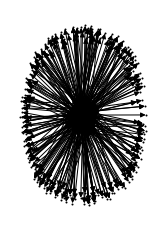

In [10]:
option = {
    'node_color': 'black',
    'node_size': 1,
    'width': 1,
}
plt.subplot(121)
nx.draw(G, pos=None, ax=None, **option)
plt.show()

In [9]:
basic_stats(G)

Short info:
Name: 
Type: DiGraph
Number of nodes: 951
Number of edges: 15572
Average in degree:  16.3743
Average out degree:  16.3743
Selfloops edges: 6


### Motifs
![](images/illustration/triades.png)

In [11]:
nx.triadic_census(G)

{'003': 134535561,
 '012': 3179322,
 '102': 4388720,
 '021D': 29914,
 '021U': 13984,
 '021C': 36362,
 '111D': 103979,
 '111U': 194334,
 '030T': 1510,
 '030C': 466,
 '201': 329068,
 '120D': 2877,
 '120U': 3611,
 '120C': 5950,
 '210': 32141,
 '300': 37876}

In [12]:
import itertools


def _tricode(G, v, u, w):
    """Returns the integer code of the given triad.

    This is some fancy magic that comes from Batagelj and Mrvar's paper. It
    treats each edge joining a pair of `v`, `u`, and `w` as a bit in
    the binary representation of an integer.

    """
    combos = ((v, u, 1), (u, v, 2), (v, w, 4), (w, v, 8), (u, w, 16),
              (w, u, 32))
    return sum(x for u, v, x in combos if v in G[u])


#: The integer codes representing each type of triad.
#: Triads that are the same up to symmetry have the same code.
TRICODES = (1, 2, 2, 3, 2, 4, 6, 8, 2, 6, 5, 7, 3, 8, 7, 11, 2, 6, 4, 8, 5, 9,
            9, 13, 6, 10, 9, 14, 7, 14, 12, 15, 2, 5, 6, 7, 6, 9, 10, 14, 4, 9,
            9, 12, 8, 13, 14, 15, 3, 7, 8, 11, 7, 12, 14, 15, 8, 14, 13, 15,
            11, 15, 15, 16)

#: The names of each type of triad. The order of the elements is
#: important: it corresponds to the tricodes given in :data:`TRICODES`.
TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
               '030T', '030C', '201', '120D', '120U', '120C', '210', '300')

#: A dictionary mapping triad code to triad name.
TRICODE_TO_NAME = {i: TRIAD_NAMES[code - 1] for i, code in enumerate(TRICODES)}

triad_nodes = {name: set([]) for name in TRIAD_NAMES}
m = {v: i for i, v in enumerate(G)}
for v in G:
    vnbrs = set(G.pred[v]) | set(G.succ[v])
    for u in vnbrs:
        if m[u] > m[v]:
            unbrs = set(G.pred[u]) | set(G.succ[u])
            neighbors = (vnbrs | unbrs) - {u, v}
            not_neighbors = set(G.nodes()) - neighbors - {u, v}
            # Find dyadic triads
            for w in not_neighbors:
                if v in G[u] and u in G[v]:
                    triad_nodes['102'].add(tuple(sorted([u, v, w])))
                else:
                    triad_nodes['012'].add(tuple(sorted([u, v, w])))
            for w in neighbors:
                if m[u] < m[w] or (m[v] < m[w] < m[u] and
                                   v not in G.pred[w] and
                                   v not in G.succ[w]):
                    code = _tricode(G, v, u, w)
                    triad_nodes[TRICODE_TO_NAME[code]].add(
                        tuple(sorted([u, v, w])))
# find null triads
all_tuples = set()
for s in triad_nodes.values():
    all_tuples = all_tuples.union(s)
triad_nodes['003'] = set(itertools.combinations(G.nodes(), 3)).difference(all_tuples)

In [14]:
triad_nodes

{'003': {(795, 886, 941),
  (134, 519, 534),
  (609, 820, 863),
  (595, 718, 813),
  (60, 96, 189),
  (547, 744, 782),
  (884, 905, 935),
  (175, 624, 865),
  (144, 490, 871),
  (241, 281, 759),
  (34, 69, 526),
  (397, 421, 441),
  (256, 599, 724),
  (371, 478, 679),
  (89, 272, 735),
  (134, 267, 276),
  (357, 664, 725),
  (41, 110, 412),
  (200, 509, 876),
  (468, 589, 678),
  (123, 272, 836),
  (185, 393, 872),
  (75, 218, 685),
  (234, 549, 829),
  (279, 476, 758),
  (186, 379, 830),
  (219, 409, 831),
  (423, 547, 634),
  (93, 444, 844),
  (297, 452, 931),
  (171, 483, 826),
  (204, 337, 829),
  (94, 308, 890),
  (253, 409, 490),
  (282, 434, 933),
  (267, 296, 935),
  (508, 706, 949),
  (193, 292, 432),
  (496, 788, 852),
  (163, 553, 588),
  (448, 542, 903),
  (86, 366, 500),
  (212, 406, 671),
  (38, 404, 743),
  (149, 335, 634),
  (246, 402, 906),
  (434, 728, 945),
  (248, 712, 747),
  (41, 354, 426),
  (11, 99, 462),
  (281, 807, 841),
  (45, 159, 249),
  (204, 556, 841),
 

In [15]:
triad_nodes.keys()

dict_keys(['003', '012', '102', '021D', '021U', '021C', '111D', '111U', '030T', '030C', '201', '120D', '120U', '120C', '210', '300'])

### Раcпарсим результаты
 и для каждого города построим вектор признаков - количество вхождений в мотифы 

In [16]:
codeCityMotifCounts = {}

for item in codeCity:
    codeCityMotifCounts[item] = {
        'triplets': [0 for i in range(16)]
    }
codeCityMotifCounts

{1: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 2: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 3: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 4: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 5: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 6: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 7: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 8: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 9: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 10: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 11: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 12: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 13: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 14: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 15: {'triplets': [0, 0, 0, 0, 0, 0, 0, 0, 

In [17]:
for i, j in enumerate(triad_nodes.keys()):
    for k in triad_nodes[j]:
        for m in k:
            codeCityMotifCounts[m]['triplets'][i] += 1

In [18]:
codeCityMotifCounts[cityCode['Москва']]['triplets']

[63467,
 44980,
 165695,
 6217,
 95,
 1580,
 6530,
 52341,
 4,
 1,
 101914,
 57,
 165,
 110,
 3034,
 4585]

## Сформируем матрицу признаков вершин

In [21]:
X = []
for item in range(len(codeCityMotifCounts)):
    X.append(codeCityMotifCounts[item+1]['triplets'])

In [22]:
print(X)

[[438243, 4874, 6671, 131, 0, 21, 28, 584, 0, 0, 217, 0, 1, 0, 4, 1], [440097, 3899, 6776, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0], [435617, 6346, 7619, 3, 7, 15, 97, 234, 0, 0, 819, 1, 1, 2, 9, 5], [408960, 15929, 22275, 84, 96, 143, 634, 648, 8, 2, 1675, 12, 20, 20, 129, 140], [439815, 4973, 5319, 129, 0, 25, 0, 513, 0, 0, 0, 0, 1, 0, 0, 0], [440686, 4131, 5366, 111, 0, 14, 0, 467, 0, 0, 0, 0, 0, 0, 0, 0], [440305, 3837, 6422, 0, 0, 0, 30, 33, 0, 0, 148, 0, 0, 0, 0, 0], [439840, 4937, 5305, 133, 0, 32, 0, 527, 0, 0, 0, 0, 1, 0, 0, 0], [438797, 3773, 7609, 0, 0, 0, 14, 113, 0, 0, 466, 0, 0, 0, 0, 3], [434785, 9482, 5200, 120, 5, 66, 18, 620, 2, 0, 460, 0, 11, 0, 6, 0], [414890, 17704, 15218, 189, 63, 183, 260, 878, 13, 1, 1117, 17, 25, 31, 116, 70], [435835, 7195, 6337, 161, 31, 82, 175, 692, 0, 0, 246, 1, 3, 6, 10, 1], [439223, 3700, 6830, 0, 0, 0, 36, 164, 0, 0, 819, 0, 0, 0, 0, 3], [407131, 15021, 23309, 96, 114, 227, 825, 967, 7, 5, 2494, 17, 16, 31, 269, 246], [436661, 5622, 8140,

# Ёё-то мы и будем сворачивать 
способом предложенным https://tkipf.github.io/graph-convolutional-networks/
и методом, предложенным @iggisv9t (картинка - для понимания происходящего,только учтите, что **у нас выборка равна множеству соседей**)

![alt text](https://habrastorage.org/webt/fe/d5/xt/fed5xts6of3j6ooup-8vtahflfc.gif)

In [ ]:
def get_adjacency_matrix(Graph):
    '''
    Beware of memory explosion! Works well for small graphs.
    Builds the adjacency matrix of a
    given graph and returns it as a numpy array
    '''
    #########################################################
    n = Graph.GetNodes()
    A = np.zeros((n,n))
    
    for EI in Graph.Edges():  
        A[EI.GetSrcNId()-1][EI.GetDstNId()-1] = 1
        A[EI.GetDstNId()-1][EI.GetSrcNId()-1] = 1
        
    return A

    #########################################################


def get_normalized_laplacian(Graph):

    '''
    Returns normalized laplacian given graph
    '''
    #########################################################
    A = get_adjacency_matrix(Graph)
    D = (csgraph.laplacian(A, normed=True))

    return D

    #########################################################


def roll_x(X, D):
    '''
    Performs Graph Convolution for a single layer
    
    Parameters:
    
    X - node features
    D - normalized laplacian

    IMPORTANT NOTE: UNLESS WE ADD WEIGHTS, PERFORMS
    STACKING OF NEIGHBOR FEATURES ~SAME AS ROL-X  
    
    Returns:
    
    X - node features concatenated with pooled neighborhood info
    
    '''
    #########################################################
    
    shape1 = X.shape[1]
    # convolution
    X = np.hstack((X, (D @ X[:, -shape1:])))
    
    return X

    #########################################################


def graph_convolution(X, D, relu='on'):
    '''
    Performs Graph Convolution for a single layer
    
    Parameters:
    
    X - node features
    D - normalized laplacian
    relu - non-linear activation, just turn it off for the output layer
    
    Returns:
    
    X - node features concatenated with pooled neighborhood info
    
    '''
    #########################################################
    
    shape1 = X.shape[1]
    # random weights
    W = np.random.rand(shape1,5)*2 - 1
    # convolution
    Xc = D @ X @ W
    # ReLU
    if relu == 'on':
        Xc = Xc * (Xc>0)
    # combine input & convoluted features
    X = np.hstack((X, Xc))
    
    return X

    #########################################################


# Случай первый - линейный
механика работы графовой свёрточной сети - сбор свойств окружающих вершин - тот же самый алгоритм RolX (https://web.eecs.umich.edu/~dkoutra/papers/12-kdd-recursiverole.pdf)

In [ ]:
D = get_normalized_laplacian(G)
Xl = np.array(X)

for i in range(3):
    Xl = roll_x(Xl, D)

# индексация в матрице связности отличается на -1
Xl[cityCode['Москва']-1]

# Посмотрим, кластеризуются ли полученные вектора
и сколько структурных ролей можно выделить

In [ ]:
def compactness_check(XXX):
    inertia = []
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(XXX)
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.plot(range(1, 20), inertia, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$');

compactness_check(Xl)

# Похоже, 5-7 структурных ролей присутствует

In [ ]:
CLUSTERS = 7
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(Xl)
y_pred = KMeans(n_clusters=CLUSTERS, random_state=42).fit_predict(Xl)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y_pred);

# Посмотрим, что там за кластера получились
(самые небольшие по размеру)

In [ ]:
cityCodeCluster = { x: [] for x in range(CLUSTERS)}

for item in range(1,len(cityCode)+1):
    cityCodeCluster[y_pred[item-1]].append(codeCity[item]) 

for item in cityCodeCluster:
    if len(cityCodeCluster[item]) < 30:
        print(cityCodeCluster[item])

# Случай второй - добавим нелинейности
и получим более компактные представления вершин-городов

In [ ]:
Xn = np.array(X)

# подготовим данные в виде приятном для нейронок
Xn = xlogy(np.sign(Xn), Xn) / np.log(2)
Xn = Normalizer().fit_transform(Xn)

for i in range(2):
    Xn = graph_convolution(Xn, D)
Xn = graph_convolution(Xn, D, relu='off')

# индексация в матрице связности отличается на -1
Xn[cityCode['Москва']-1]

# Обратите внимание:
последние 5 колонок - результат трёх слоёв свёртки - наши эмбеддинги

In [ ]:
Xt = Xn[:, -5:]
Xt[cityCode['Москва']-1]

In [ ]:
compactness_check(Xn)

In [ ]:
CLUSTERS = 7
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(Xn)
y_pred = KMeans(n_clusters=CLUSTERS, random_state=42).fit_predict(Xn)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y_pred);

In [ ]:
cityCodeCluster = { x: [] for x in range(CLUSTERS)}
cityCodeVector = {}

for item in range(1,len(cityCode)+1):
    cityCodeCluster[y_pred[item-1]].append(codeCity[item]) 
    cityCodeVector[item] = Xn[item-1]

for item in cityCodeCluster:
    if len(cityCodeCluster[item]) < 40:
        print(cityCodeCluster[item])

# Оценим, как эти вектора разделяют города и веси

In [ ]:
compactness_check(Xt)

In [ ]:
CLUSTERS = 7
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(Xt)
y_pred = KMeans(n_clusters=CLUSTERS, random_state=42).fit_predict(Xt)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y_pred);

In [ ]:
cityCodeCluster = { x: [] for x in range(CLUSTERS)}
cityCodeVector = {}

for item in range(1,len(cityCode)+1):
    cityCodeCluster[y_pred[item-1]].append(codeCity[item]) 
    cityCodeVector[item] = Xt[item-1]

for item in cityCodeCluster:
    if len(cityCodeCluster[item]) < 40:
        print(cityCodeCluster[item])

# В результате мы получили два набора векторов свойств, приводящих к похожим результатам кластеризации
Теперь можно провести операцию пулинга и рассуждать о подобии социо-экономической структуры регионов, построенной из потоков пассажироперевозок

In [ ]:
SR = df[['sourceId', 'source_region']].groupby('sourceId').first().to_dict()['source_region']
TR = df[['targetId', 'target_region']].groupby('targetId').first().to_dict()['target_region']
SC = df[['sourceId', 'source_county']].groupby('sourceId').first().to_dict()['source_county']
TC = df[['targetId', 'target_county']].groupby('targetId').first().to_dict()['target_county']

cities = []

for item in range(1,len(codeCity)+1):
    cities.append((item, codeCity[item]))

cf = pd.DataFrame(cities, columns=['Code', 'City'])

cf['Region'] = cf['Code'].map(SR)
cf['Region'] = cf['Code'].map(TR)

cf['County'] = cf['Code'].map(SC)
cf['County'] = cf['Code'].map(TC)

cf['FeatureVectorGlobal'] = cf['Code'].map(cityCodeVector)

cf.head()

In [ ]:
rf = cf[['Region', 'FeatureVectorGlobal']].groupby('Region').agg(list)
regionVectors = {}

for item in rf.itertuples():
    Z = np.array(item[1])
    regionVectors[item[0]] = list(np.average(Z, axis=0))

cf['RegionFeatureVectorGlobal'] = cf['Region'].map(regionVectors)
cf.head()

# Всё описанное можно повторить для отдельных видов транспорта
(подсказка - достаточно убрать комментарии в первой ячейке)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
% cd ..

In [ ]:
% cd ./gdrive

In [ ]:
cd ./'My Drive'

In [ ]:
cf.to_csv('Covid-19-tutu-Region-Vectors.csv', sep=';')
#cf.to_csv('Covid-19-tutu-Region-Vectors-Avia.csv', sep=';')
#cf.to_csv('Covid-19-tutu-Region-Vectors-Train.csv', sep=';')
#cf.to_csv('Covid-19-tutu-Region-Vectors-Bus.csv', sep=';')

In [ ]:
% cd ../../